# Classification project

The goal is to build a classification model to predict if median housing prices in some districts are below or above a certain level (150000).

Note

>This notebook shall be a cleaned up version of the previous classification notebook. It will not cover everything from the classification notebook (only one model). And I try to avoid some mistakes I made in the original notebook. Moreover Ill try to do the data split before I start with the work on the data

## Plan
### Identify Use Case
We want to build a classification model for the median house price for districts. Goal is to predict if the median house price is above or below 150000$. We want to train the data, evaluate models and test them with the test data set. Therefore we need to split the data before we start with the modelling. We are owning a insurance company which wants to predict the prices of houses in certain districts based on various variables.

### Frame problem
There are some variables in the table which are not necessary and can be dropped. Moreover we need to adjust the data in the table so that it can be worked with them. E.g. Data needs to be preprocessed, cleaned and variables need to be adjusted (total_rooms & total_bedrooms need to be adapted so that it is in average for each house). For new districts we want to predict the house prices so that we can adapt our insurance model.

### Identify variables
- Our response variable is the median_house_value, which shall be predicted after we built the model and trained and tested it. If the price_category is set correclty then this is the response variable, to see if the price is above or below the median house price. Basically both variables are important as response variables for our model, but we can only use the price_category.
- longitude and latitude can be dropped, that wont effect the data. Because both only make sense combined. Althought the location of a house affects the price, in this case both are only useful combined and each row display a whole district. So the longitude and latitude data it self wont affect the housing price in a logical order
- The price category needs to be double checked if the values are correct.
- housing_median__age is a useful variable and shall be used as a predictor
- total_rooms and total_bedrooms need to be reduced to the average per household otherwise it does not make sense
- population and household makes sense to use for the data model. Even thought both affect each other. If there are more people, there will be also more households. The data analysis will show how to use them
- median_income is a useful variable and shall be used as a predictor
- ocean_proximity is a useful variable and shall be used as a predictor

### Define metrics
The goal of our company is to predict as many house prices as possible correct out of the actual data. Therefore we want to reduce the false negatives and focus on a model with a high recall. Goal is to have a model with a recall value above 80%.

## Python setup

In [76]:
import pandas as pd
import seaborn as sns
import numpy as np 

import statsmodels.api as sm 
from statsmodels.formula.api import ols 
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from scipy.stats import chi2_contingency, fisher_exact

import matplotlib.pyplot as plt


sns.set_theme()
%matplotlib inline

## Import Data/Data Ingestion

In [77]:
# import data 
# in this case I have used a formula from stackoverflow, because I was not able to make it work with ROOT + DATA or the other formulas from the notebooks
# Link to stackoverflow: https://stackoverflow.com/questions/55240330/how-to-read-csv-file-from-github-using-pandas 

url = "https://raw.githubusercontent.com/jan-kirenz/project-DanielSteck/main/project_data.csv?token=GHSAT0AAAAAABP5WYYS3N7LIECOFSXXBYGMYPLZQ3A"
df = pd.read_csv(url)

In [78]:
# check if data import was succesful
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,price_category
0,-122.23,37.88,41.0years,880,129.0,322,126,8.3252,452600.0$,NEAR BAY,above
1,-122.22,37.86,21.0,7099,1106.0,2401,1138,8.3014,358500.0,NEAR BAY,above
2,-122.24,37.85,52.0,1467,190.0,496,177,7.2574,352100.0,NEAR BAY,above
3,-122.25,37.85,52.0,1274,235.0,558,219,5.6431,341300.0,NEAR BAY,above
4,-122.25,37.85,52.0,1627,280.0,565,259,3.8462,342200.0,NEAR BAY,above
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665,374.0,845,330,1.5603,78100.0,INLAND,above
20636,-121.21,39.49,18.0,697,150.0,356,114,2.5568,77100.0,INLAND,above
20637,-121.22,39.43,17.0,2254,485.0,1007,433,1.7000,92300.0,INLAND,above
20638,-121.32,39.43,18.0,1860,409.0,741,349,1.8672,84700.0,INLAND,above


In [79]:
# data overview (with meta data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  object 
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  object 
 9   ocean_proximity     20640 non-null  object 
 10  price_category      20640 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 1.7+ MB


In [80]:
# show all variables in the data set
df. columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'price_category'],
      dtype='object')

**Explanation for the columns** :

- housing_median_age: Median age of a house within a district; a lower number is a newer building
- total_rooms: Total number of rooms within a district
- total_bedrooms: Total number of bedrooms within a district
- population: Total number of people residing within a district
- households: Total number of households, a group of people residing within a home unit, for a district
- median_income: Median income for households within a district of houses (measured in tens of thousands of US Dollars)
- median_house_value: Median house value within a district (measured in US Dollars)
- ocean_proximity: Location of the district
- price_category: Indicator variable made from median_house_value (if median house value is below or above 150000)

### Clean Data
First line (line 0) has to wrong values (housing median age: 41years and median_house_value). Since there is only this row affected and the data seems correct, it will be manually adapted.

Afterwards the data type can be changed to float64 (int64 would also be possible, but it might be possible, that there might decimal places)

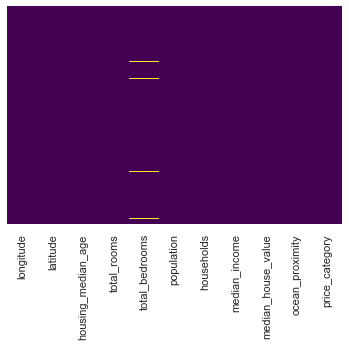

In [81]:
# show missing values (missing values - if present - will be displayed in yellow)
sns.heatmap(df.isnull(), 
            yticklabels=False,
            cbar=False, 
            cmap='viridis');


In [82]:
print(df.isnull().sum())

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
price_category          0
dtype: int64


There are 207 lines where we do not have a value for the amount of total bedrooms!

What was learned from the data Inscpetion:

- First line (line 0) has to wrong values (housing median age: 41years and median_house_value). I will manually adjust these data, so that it will be correct, instead of dropping the whole line. Afterwards the data type can be changed to float64 (int64 would also be possible, but it might be possible, that there might decimal places)
- There are 207 lines where we do not have a value for the amount of total bedrooms! --> Normally the preprocessor pipeline would take care of that, but I do not know how to use it in the classification, that is why I am removing these rows before the data split.

In [83]:
# replace the data in line 0
df['housing_median_age'] = df['housing_median_age'].replace(['41.0years'], '41.0')
df['median_house_value'] = df['median_house_value'].replace(['452600.0$'], '452600.0')

# change data type
df['housing_median_age'] = pd.Float64Index(df['housing_median_age'])
df['median_house_value'] = pd.Float64Index(df['median_house_value'])
df['ocean_proximity'] =pd.Categorical(df['ocean_proximity'])
df['price_category'] =pd.Categorical(df['price_category'])

# check the data
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,price_category
0,-122.23,37.88,41.0,880,129.0,322,126,8.3252,452600.0,NEAR BAY,above
1,-122.22,37.86,21.0,7099,1106.0,2401,1138,8.3014,358500.0,NEAR BAY,above
2,-122.24,37.85,52.0,1467,190.0,496,177,7.2574,352100.0,NEAR BAY,above
3,-122.25,37.85,52.0,1274,235.0,558,219,5.6431,341300.0,NEAR BAY,above
4,-122.25,37.85,52.0,1627,280.0,565,259,3.8462,342200.0,NEAR BAY,above
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665,374.0,845,330,1.5603,78100.0,INLAND,above
20636,-121.21,39.49,18.0,697,150.0,356,114,2.5568,77100.0,INLAND,above
20637,-121.22,39.43,17.0,2254,485.0,1007,433,1.7000,92300.0,INLAND,above
20638,-121.32,39.43,18.0,1860,409.0,741,349,1.8672,84700.0,INLAND,above


In [84]:
# check if the data types were changed succesfully
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float64 
 1   latitude            20640 non-null  float64 
 2   housing_median_age  20640 non-null  float64 
 3   total_rooms         20640 non-null  int64   
 4   total_bedrooms      20433 non-null  float64 
 5   population          20640 non-null  int64   
 6   households          20640 non-null  int64   
 7   median_income       20640 non-null  float64 
 8   median_house_value  20640 non-null  float64 
 9   ocean_proximity     20640 non-null  category
 10  price_category      20640 non-null  category
dtypes: category(2), float64(6), int64(3)
memory usage: 1.5 MB


In [85]:
# change column name, so that the naming is similar to the other colum names

df.rename(columns = {
    "housing_median_age": "median_housing_age"},
inplace=True)

df

,longitude,latitude,median_housing_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,price_category
0,-122.23,37.88,41.0,880,129.0,322,126,8.3252,452600.0,NEAR BAY,above
1,-122.22,37.86,21.0,7099,1106.0,2401,1138,8.3014,358500.0,NEAR BAY,above
2,-122.24,37.85,52.0,1467,190.0,496,177,7.2574,352100.0,NEAR BAY,above
3,-122.25,37.85,52.0,1274,235.0,558,219,5.6431,341300.0,NEAR BAY,above
4,-122.25,37.85,52.0,1627,280.0,565,259,3.8462,342200.0,NEAR BAY,above
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665,374.0,845,330,1.5603,78100.0,INLAND,above
20636,-121.21,39.49,18.0,697,150.0,356,114,2.5568,77100.0,INLAND,above
20637,-121.22,39.43,17.0,2254,485.0,1007,433,1.7000,92300.0,INLAND,above
20638,-121.32,39.43,18.0,1860,409.0,741,349,1.8672,84700.0,INLAND,above


Dropping irrelevant features: longitude, latitude wont affect the median_house_value.

In [86]:
# Drop irrelevant features
df = df.drop(['longitude', 'latitude'], axis=1)

Adding new colums to the table.

Background: Total_rooms & total_bedrooms is not comparable if in one district are 100 households and in one 500 households --> calculation per household Also for the avg. size per household to see how big the household and therefore the flat is (even though it is already included in the avg_rooms_per_household)

Moreover the unit from median_income has to be identical to the unit from median_house_value. Thats why both will be in $.

Afterwards the total_rooms and total_bedrooms can be dropped, because it is already included via the avg_per_household

In [87]:
# calculate average rooms per household: total_rooms/households
df['avg_rooms_per_household'] = round(df['total_rooms']/df['households'],2)
# calculate average bedrooms per households: total_bedromms/ househols
df['avg_bedrooms_per_household'] = round(df['total_bedrooms']/df['households'],2)
# calculate average household size: population/households
df['avg_size_per_household'] = round(df['population']/df['households'],2)

# get the median income in $ and not in 10.000$
df['median_income']= df['median_income']*10000

df = df.drop(['total_rooms', 'total_bedrooms'], axis=1)

df

,median_housing_age,population,households,median_income,median_house_value,ocean_proximity,price_category,avg_rooms_per_household,avg_bedrooms_per_household,avg_size_per_household
0,41.0,322,126,83252.0,452600.0,NEAR BAY,above,6.98,1.02,2.56
1,21.0,2401,1138,83014.0,358500.0,NEAR BAY,above,6.24,0.97,2.11
2,52.0,496,177,72574.0,352100.0,NEAR BAY,above,8.29,1.07,2.80
3,52.0,558,219,56431.0,341300.0,NEAR BAY,above,5.82,1.07,2.55
4,52.0,565,259,38462.0,342200.0,NEAR BAY,above,6.28,1.08,2.18
...,...,...,...,...,...,...,...,...,...,...
20635,25.0,845,330,15603.0,78100.0,INLAND,above,5.05,1.13,2.56
20636,18.0,356,114,25568.0,77100.0,INLAND,above,6.11,1.32,3.12
20637,17.0,1007,433,17000.0,92300.0,INLAND,above,5.21,1.12,2.33
20638,18.0,741,349,18672.0,84700.0,INLAND,above,5.33,1.17,2.12


In [88]:
# drop remaining rows with one missing value
df = df.dropna()

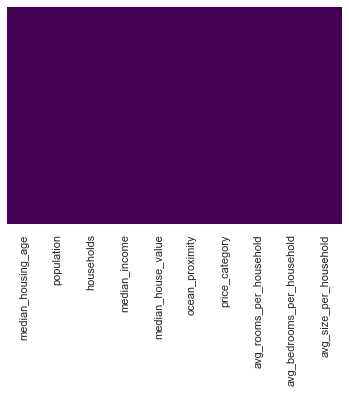

In [89]:
# show missing values --> Check if the lines were dropped successfully
sns.heatmap(df.isnull(), 
            yticklabels=False,
            cbar=False, 
            cmap='viridis');

In [90]:
# check column-wise distribution of null values
print(df.isnull().sum())

median_housing_age            0
population                    0
households                    0
median_income                 0
median_house_value            0
ocean_proximity               0
price_category                0
avg_rooms_per_household       0
avg_bedrooms_per_household    0
avg_size_per_household        0
dtype: int64


Rows with missing values were dropped successfully

Somehow the column price_category is not correct (see tail of the dataframe). Therefore I need to overwrite the price_category with new values

In [91]:
# update the column price category. All median_house_values below 150000 are classified as "below" and all values with 150000 or more are classified as above
df['price_category'] = pd.cut(df['median_house_value'], 
                        bins = [0, 150000, float('inf')], 
                        labels = ['below', ' above'])

df

C:\Users\Daniel\AppData\Local\Temp/ipykernel_11788/3537981358.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_category'] = pd.cut(df['median_house_value'],


,median_housing_age,population,households,median_income,median_house_value,ocean_proximity,price_category,avg_rooms_per_household,avg_bedrooms_per_household,avg_size_per_household
0,41.0,322,126,83252.0,452600.0,NEAR BAY,above,6.98,1.02,2.56
1,21.0,2401,1138,83014.0,358500.0,NEAR BAY,above,6.24,0.97,2.11
2,52.0,496,177,72574.0,352100.0,NEAR BAY,above,8.29,1.07,2.80
3,52.0,558,219,56431.0,341300.0,NEAR BAY,above,5.82,1.07,2.55
4,52.0,565,259,38462.0,342200.0,NEAR BAY,above,6.28,1.08,2.18
...,...,...,...,...,...,...,...,...,...,...
20635,25.0,845,330,15603.0,78100.0,INLAND,below,5.05,1.13,2.56
20636,18.0,356,114,25568.0,77100.0,INLAND,below,6.11,1.32,3.12
20637,17.0,1007,433,17000.0,92300.0,INLAND,below,5.21,1.12,2.33
20638,18.0,741,349,18672.0,84700.0,INLAND,below,5.33,1.17,2.12


Now the price_category needs to be factorized so that I can make predictions for 0 and 1

0 = above 1 = below

In [92]:
# Note factorize() returns two objects: a label array and an array with the unique values
# Weare only interested in the first object.
# Above will be displayed as 0 and below will be displayed as 1
df['price_category2'] = df.price_category.factorize()[0]

df

C:\Users\Daniel\AppData\Local\Temp/ipykernel_11788/3287984605.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_category2'] = df.price_category.factorize()[0]


,median_housing_age,population,households,median_income,median_house_value,ocean_proximity,price_category,avg_rooms_per_household,avg_bedrooms_per_household,avg_size_per_household,price_category2
0,41.0,322,126,83252.0,452600.0,NEAR BAY,above,6.98,1.02,2.56,0
1,21.0,2401,1138,83014.0,358500.0,NEAR BAY,above,6.24,0.97,2.11,0
2,52.0,496,177,72574.0,352100.0,NEAR BAY,above,8.29,1.07,2.80,0
3,52.0,558,219,56431.0,341300.0,NEAR BAY,above,5.82,1.07,2.55,0
4,52.0,565,259,38462.0,342200.0,NEAR BAY,above,6.28,1.08,2.18,0
...,...,...,...,...,...,...,...,...,...,...,...
20635,25.0,845,330,15603.0,78100.0,INLAND,below,5.05,1.13,2.56,1
20636,18.0,356,114,25568.0,77100.0,INLAND,below,6.11,1.32,3.12,1
20637,17.0,1007,433,17000.0,92300.0,INLAND,below,5.21,1.12,2.33,1
20638,18.0,741,349,18672.0,84700.0,INLAND,below,5.33,1.17,2.12,1


## Data splitting

Median_house_value may not be used in the model, because the price_category is based on this. 

In [93]:
# prepare data for scikit learn

X = df.drop(columns = ['median_house_value', 'price_category'])
y = df['price_category2']

In [94]:
# Split the data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

Note:

> The code from World happiness report caused errors, therefore I used the example code from Online ads (which is slightly different ) to create the train_dataset

In [95]:
# Make data exploration set

train_dataset = pd.DataFrame(X_train).copy()
train_dataset['price_category2'] = pd.DataFrame(y_train)

train_dataset

,median_housing_age,population,households,median_income,ocean_proximity,avg_rooms_per_household,avg_bedrooms_per_household,avg_size_per_household,price_category2
4353,39.0,975,525,93092.0,<1H OCEAN,7.23,1.12,1.86,0
6847,42.0,656,215,41902.0,<1H OCEAN,4.82,0.93,3.05,0
18321,37.0,510,206,79029.0,NEAR BAY,6.25,0.96,2.48,0
10987,23.0,1574,642,50210.0,<1H OCEAN,5.45,0.99,2.45,0
3115,14.0,850,317,25812.0,INLAND,5.49,1.23,2.68,1
...,...,...,...,...,...,...,...,...,...
9464,47.0,552,201,25192.0,<1H OCEAN,5.72,1.21,2.75,1
7373,44.0,3913,842,30143.0,<1H OCEAN,3.78,1.04,4.65,1
17897,36.0,1589,387,31065.0,<1H OCEAN,4.71,1.06,4.11,0
7375,47.0,1097,274,28810.0,<1H OCEAN,3.86,1.08,4.00,0


## Analyze data

Note:
> In this notebook I will not remove the data outliners to ensure that I do not change anything in the results, therefore the boxplots will be including the outliners/points with high leverage
### Exploration data analysis

In [96]:
train_dataset.groupby(by=['price_category2']).describe().T

price_category2                               0              1
median_housing_age         count   10254.000000    6092.000000
                           mean       29.144919      27.741957
                           std        12.655827      12.412652
                           min         1.000000       1.000000
                           25%        19.000000      17.000000
                           50%        29.000000      27.000000
                           75%        37.000000      37.000000
                           max        52.000000      52.000000
population                 count   10254.000000    6092.000000
                           mean     1453.267310    1376.023473
                           std      1127.511574    1167.112305
                           min         3.000000       6.000000
                           25%       799.000000     764.000000
                           50%      1177.000000    1151.000000
                           75%      1754.000000    1678.000000
                           max     16305.000000   35682.000000
households                 count   10254.000000    6092.000000
                           mean      525.792374     457.282830
                           std       401.644619     351.844133
                           min         1.000000       2.000000
                           25%       293.000000     259.000000
                           50%       428.000000     381.000000
                           75%       631.750000     554.000000
                           max      5358.000000    6082.000000
median_income              count   10254.000000    6092.000000
                           mean    45744.895260   26697.458306
                           std     19615.846702    9658.643096
                           min      4999.000000    4999.000000
                           25%     32462.000000   19706.750000
                           50%     42222.000000   25625.000000
                           75%     54624.250000   32547.500000
                           max    150001.000000  150001.000000
avg_rooms_per_household    count   10254.000000    6092.000000
                           mean        5.559649       5.200432
                           std         2.430776       2.259004
                           min         1.130000       0.890000
                           25%         4.520000       4.340000
                           50%         5.390000       5.010000
                           75%         6.307500       5.670000
                           max       141.910000      62.420000
avg_bedrooms_per_household count   10254.000000    6092.000000
                           mean        1.074583       1.132329
                           std         0.384245       0.486977
                           min         0.380000       0.500000
                           25%         1.000000       1.010000
                           50%         1.040000       1.060000
                           75%         1.090000       1.130000
                           max        25.640000      15.310000
avg_size_per_household     count   10254.000000    6092.000000
                           mean        2.881922       3.191522
                           std         2.675185       7.703596
                           min         0.750000       1.160000
                           25%         2.370000       2.520000
                           50%         2.760000       2.940000
                           75%         3.170000       3.520000
                           max       230.170000     599.710000

The price category above has on average:

- **29.144919** as median_housing_age vs **27.741957** for the price category below
- **1453.267310** as population vs **1376.023473** for the price category below
- **525.792374** as households vs **457.282830** for the price category below
- **45744.895260** as median_income vs **26697.458306** for the price category below
- median_house_value will be skipped, because the price category is based on this feature
- **5.559649** as avg_rooms_per_household vs **5.200432** for the price category below

--> for all these features the mean is higher for the price_category above

- **1.074583** as avg_bedrooms_per_household vs **1.132329** for the price category below

--> This does not make sense, because theprice catogory which is cheaper has on average more bedrooms... Moreover this variable has almost no distribution (75% of the data is between 1.0 and 1.09/1.13)

- **2.854143** as avg_size_per_household vs **3.094138** for the price category below 

--> here the mean for the price_category below, which also makes sense, because people with more money can afford to life on their owen. Moreover those people often focus more on their careers instead of their family (my interpretation)

The standard deviations are quite high... So I have the situation in which data points are widely spread from the mean.

### Distribution

Visualization of differences

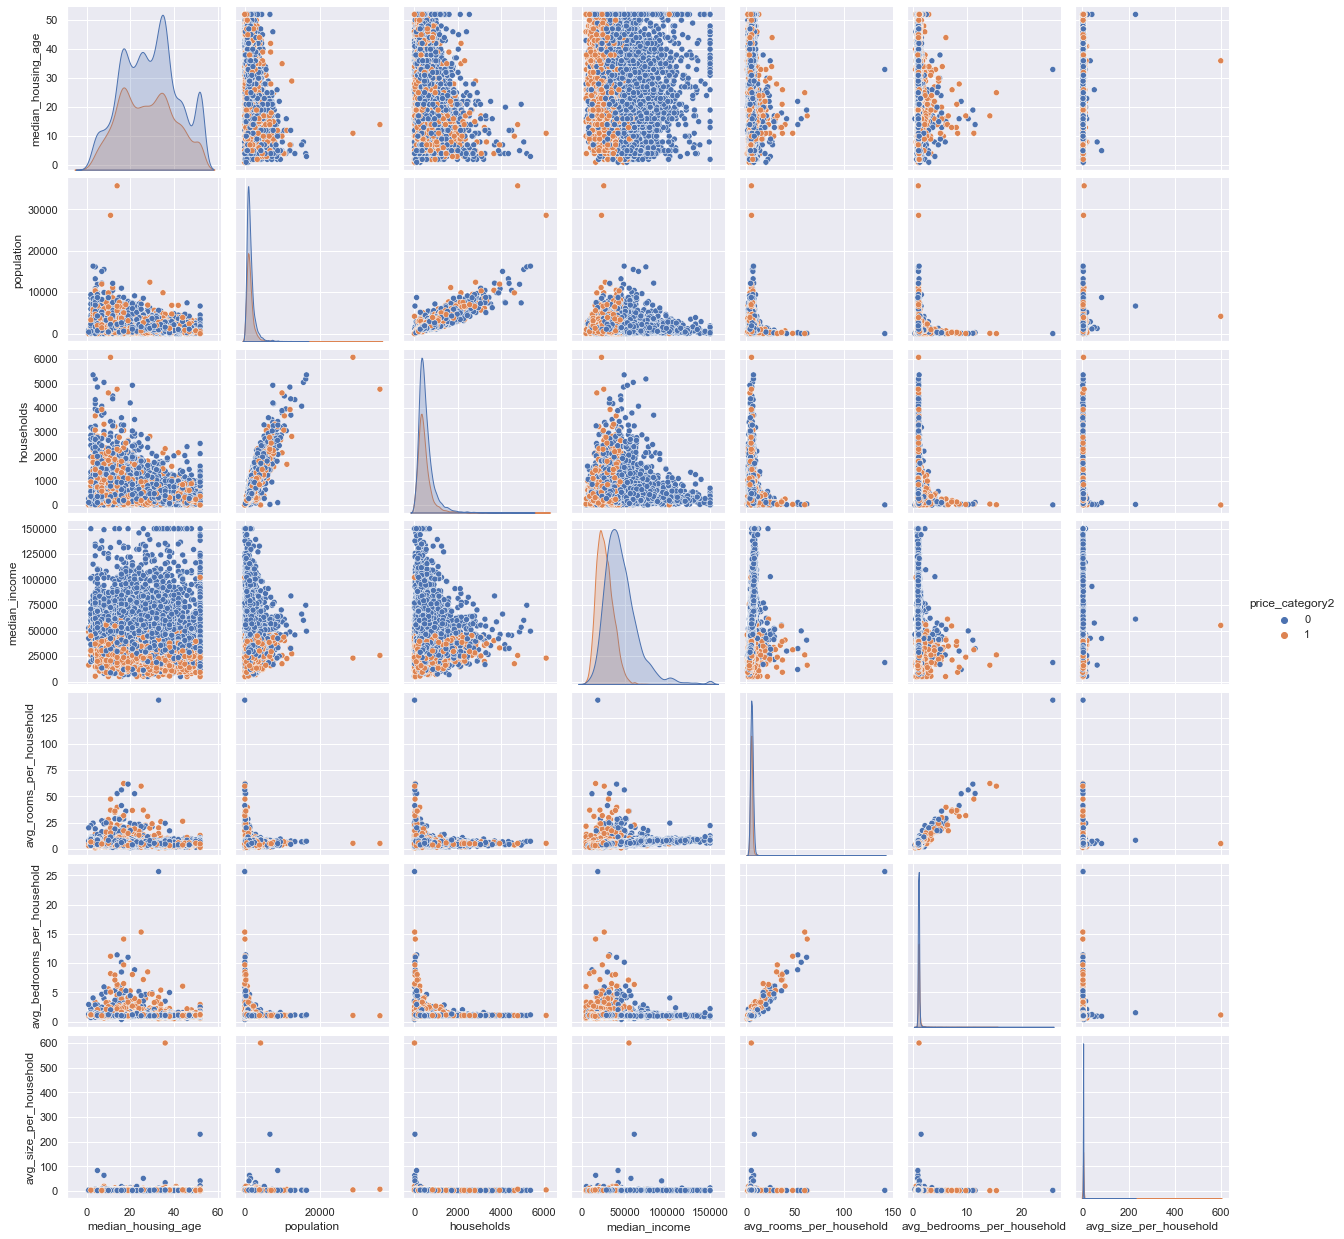

In [97]:
sns.pairplot(hue="price_category2", data=train_dataset)

It is hard to see any differences here, therefore I will analyze each variable 

<AxesSubplot:xlabel='median_housing_age', ylabel='Density'>

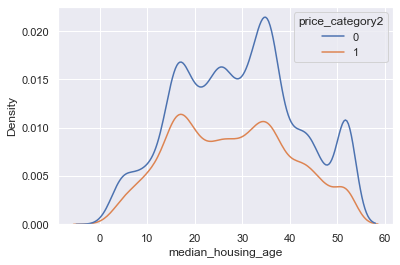

In [98]:
sns.kdeplot(hue="price_category2", x='median_housing_age', data=train_dataset)

Only a minor difference can be seen here (two peakes for price category above). 

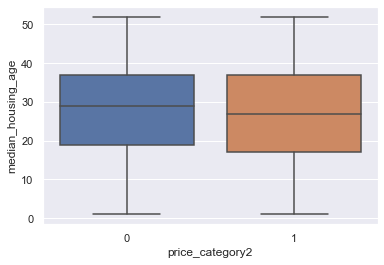

In [99]:
sns.boxplot(x="price_category2", y="median_housing_age", data=train_dataset);

Only a minor difference can be seen here, but it is very small

<AxesSubplot:xlabel='population', ylabel='Density'>

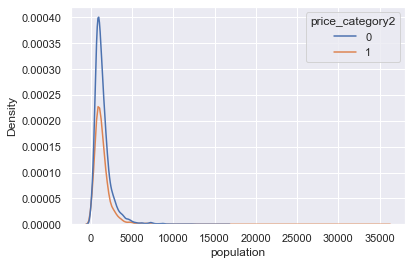

In [100]:
sns.kdeplot(hue="price_category2", x='population', data=train_dataset)

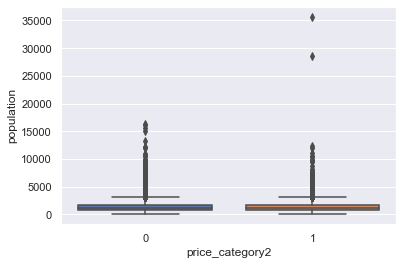

In [101]:
sns.boxplot(x="price_category2", y="population", data=train_dataset);

Only a minor difference can be seen here, but it is very small

<AxesSubplot:xlabel='households', ylabel='Density'>

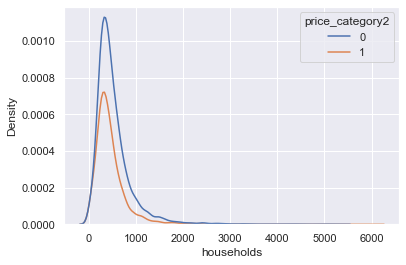

In [102]:
sns.kdeplot(hue="price_category2", x='households', data=train_dataset)

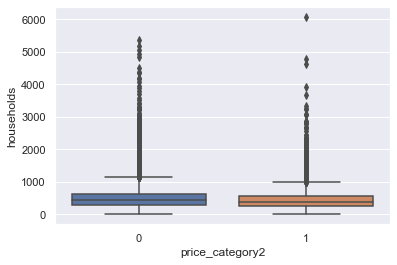

In [103]:
sns.boxplot(x="price_category2", y="households", data=train_dataset);

Only a minor difference can be seen here, but it is very small

<AxesSubplot:xlabel='median_income', ylabel='Density'>

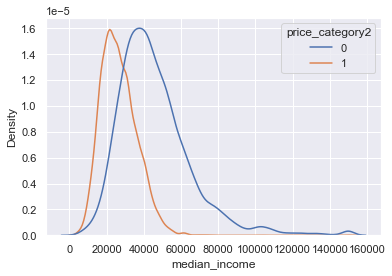

In [104]:
sns.kdeplot(hue="price_category2", x='median_income', data=train_dataset)

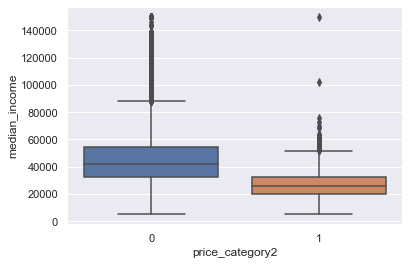

In [105]:
sns.boxplot(x="price_category2", y="median_income", data=train_dataset);

For this variable a difference can be seen. The median income is higher for the price category above!
--> this variable will be used for the model

<AxesSubplot:xlabel='avg_rooms_per_household', ylabel='Density'>

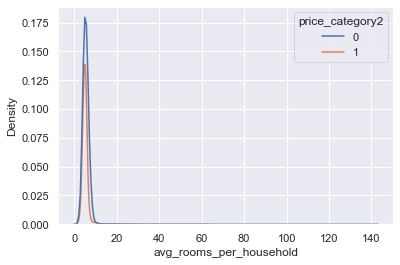

In [106]:
sns.kdeplot(hue="price_category2", x='avg_rooms_per_household', data=train_dataset)

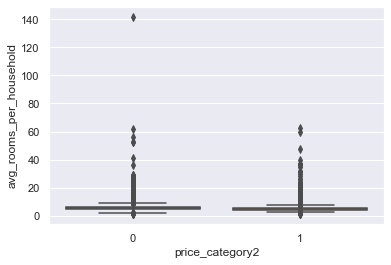

In [107]:
sns.boxplot(x="price_category2", y="avg_rooms_per_household", data=train_dataset);

Only a minor difference can be seen here, but it is very small

<AxesSubplot:xlabel='avg_bedrooms_per_household', ylabel='Density'>

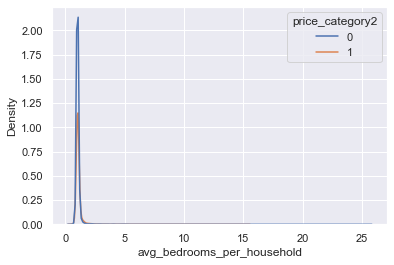

In [108]:
sns.kdeplot(hue="price_category2", x='avg_bedrooms_per_household', data=train_dataset)

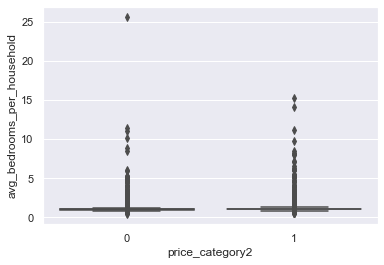

In [109]:
sns.boxplot(x="price_category2", y="avg_bedrooms_per_household", data=train_dataset);

Only a minor difference can be seen here, but it is very small

<AxesSubplot:xlabel='avg_size_per_household', ylabel='Density'>

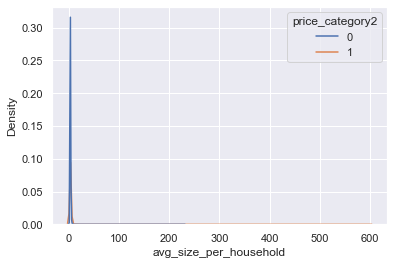

In [110]:
sns.kdeplot(hue="price_category2", x='avg_size_per_household', data=train_dataset)

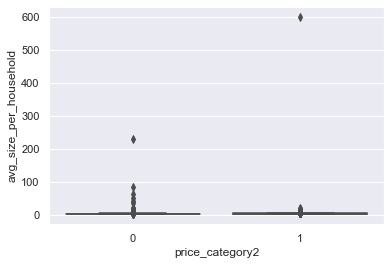

In [111]:
sns.boxplot(x="price_category2", y="avg_size_per_household", data=train_dataset);

Only a minor difference can be seen here, but it is very small

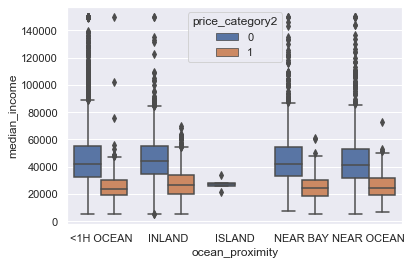

In [112]:
sns.boxplot(x="ocean_proximity", y="median_income", hue="price_category2", data=train_dataset);

To be honest, I can not interpretate this. It looks like there is no influence.
It would be also possible to use median_house_value instead of median_income. But I do not know if this is possible(allowed), because my price_category is based on the median_house_value

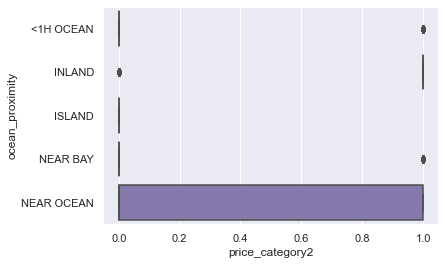

In [113]:
sns.boxplot(x="price_category2", y="ocean_proximity", data=train_dataset);

## Correlation

In [114]:
# Create correlation matrix for numerical variables
# Zusammenhang zwischen 2 Variablen, korrelationskoeffizient bewegt sich zwischen -1 und +1
corr_matrix = train_dataset.corr()
corr_matrix

,median_housing_age,population,households,median_income,avg_rooms_per_household,avg_bedrooms_per_household,avg_size_per_household,price_category2
median_housing_age,1.000000,-0.290676,-0.298956,-0.118533,-0.159107,-0.085167,0.007187,-0.053910
population,-0.290676,1.000000,0.905457,0.001413,-0.073562,-0.069351,0.063843,-0.032677
households,-0.298956,0.905457,1.000000,0.009405,-0.083166,-0.056585,-0.037716,-0.085986
median_income,-0.118533,0.001413,0.009405,1.000000,0.341320,-0.072319,0.000913,-0.484770
avg_rooms_per_household,-0.159107,-0.073562,-0.083166,0.341320,1.000000,0.832519,-0.004603,-0.073150
avg_bedrooms_per_household,-0.085167,-0.069351,-0.056585,-0.072319,0.832519,1.000000,-0.007253,0.065493
avg_size_per_household,0.007187,0.063843,-0.037716,0.000913,-0.004603,-0.007253,1.000000,0.029011
price_category2,-0.053910,-0.032677,-0.085986,-0.484770,-0.073150,0.065493,0.029011,1.000000


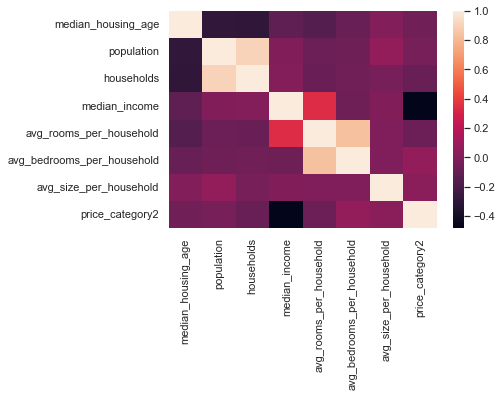

In [115]:
# Simple heatmap
heatmap = sns.heatmap(corr_matrix)

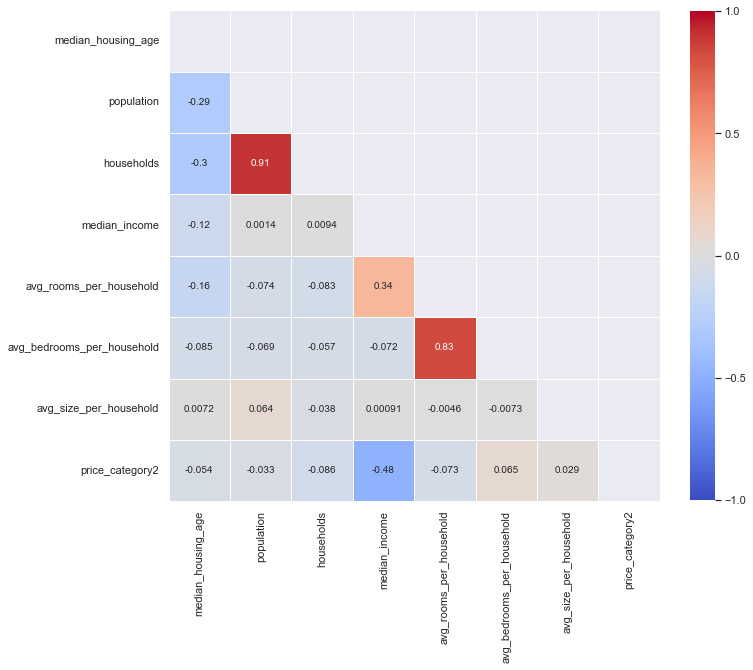

In [116]:
# Make a pretty heatmap

# Use a mask to plot only part of a matrix
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)]= True

# Change size
plt.subplots(figsize=(11, 15))

# Build heatmap with additional options
heatmap = sns.heatmap(corr_matrix, 
                      mask = mask, 
                      square = True, 
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .6,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 10})

It can be seen that 2 variables have a big impact on the price_category2. On the one hand the median_income and on the other hand the median_house_value. The problem is that the seconed variable is excluded from our model as it already includes the solution, therefore it can not be added to the model.

### VIF Factor


In [117]:
from patsy import dmatrices

y, X =dmatrices('price_category2 ~ median_housing_age + population + households + median_income + avg_rooms_per_household + avg_bedrooms_per_household + avg_size_per_household + ocean_proximity', train_dataset, return_type='dataframe')

# For each X. calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range (X.shape[1])]
vif["Feature"] = X.columns

vif.round(2)

,VIF Factor,Feature
0,36.49,Intercept
1,1.50,ocean_proximity[T.INLAND]
2,1.00,ocean_proximity[T.ISLAND]
3,1.19,ocean_proximity[T.NEAR BAY]
4,1.14,ocean_proximity[T.NEAR OCEAN]
5,1.30,median_housing_age
6,6.10,population
7,6.19,households
8,2.65,median_income
9,8.17,avg_rooms_per_household


Interpretation from the VIF factor. Almost all variables have a very high VIF Factor (above 5). Therefore these should be excluded from the model.
The only variables left are:

- Ocean_proximity
- median_housing_age
- median_income
- avg_size_per_household

Process with various models will be skipped here, It was already made at the classification notebook

## Feature engineering

This step was already made at the start of the notebook. After understanding the data I made more logicall variables and changed the unit from median_income. That is why here is no further feature engineering.

## Model 

In this notebook I will only work with one model, as I already have the step included with various models in the classification notebook (Note in this classification notebook I assume I made some steps in the wrong order or did some steps wrong).

Moreover at this point, the data (train dataset) should be splitted in a training and validation set (with k-fold cross validation). The model should be trained with the training data set. The validation of the model should then be made on the validation set, when this seems to be successful, then the final evaluation can be done on the test set.
But this step will be skipped, because I do not know how to split the already splitted data one more time and how to perform the k-fold cross validation. Moreover Feedback from 22.12 was, that we do not need to perform the k-fold cross-validation.

### Model with statsmodel



In [118]:
import statsmodels.formula.api as smf

model = smf.glm(formula = 'price_category2 ~ median_income + ocean_proximity + avg_size_per_household + median_housing_age' , data=train_dataset, family=sm.families.Binomial()).fit()

In [119]:
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        price_category2   No. Observations:                16346
Model:                            GLM   Df Residuals:                    16338
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5858.6
Date:                Wed, 19 Jan 2022   Deviance:                       11717.
Time:                        19:45:17   Pearson chi2:                 4.50e+15
No. Iterations:                    20                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

No p values higher than 5% (excepts Ocean_proximity Island, but this is included in the ocean_proximity which generally improves the model. Is it possible to drop is seperatly out?). Therefore no adaption of the model is necessary

## Thresholds

In [120]:
# Predict and join probabilty to original dataframe
train_dataset['y_score'] = model.predict()

train_dataset

,median_housing_age,population,households,median_income,ocean_proximity,avg_rooms_per_household,avg_bedrooms_per_household,avg_size_per_household,price_category2,y_score
4353,39.0,975,525,93092.0,<1H OCEAN,7.23,1.12,1.86,0,0.000078
6847,42.0,656,215,41902.0,<1H OCEAN,4.82,0.93,3.05,0,0.056783
18321,37.0,510,206,79029.0,NEAR BAY,6.25,0.96,2.48,0,0.000799
10987,23.0,1574,642,50210.0,<1H OCEAN,5.45,0.99,2.45,0,0.021542
3115,14.0,850,317,25812.0,INLAND,5.49,1.23,2.68,1,0.913245
...,...,...,...,...,...,...,...,...,...,...
9464,47.0,552,201,25192.0,<1H OCEAN,5.72,1.21,2.75,1,0.311115
7373,44.0,3913,842,30143.0,<1H OCEAN,3.78,1.04,4.65,1,0.258512
17897,36.0,1589,387,31065.0,<1H OCEAN,4.71,1.06,4.11,0,0.230778
7375,47.0,1097,274,28810.0,<1H OCEAN,3.86,1.08,4.00,0,0.263792


In [121]:
# Use thresholds to discretize Probability
train_dataset['thresh_04'] = np.where(train_dataset['y_score'] > 0.4, 1, 0)
train_dataset['thresh_05'] = np.where(train_dataset['y_score'] > 0.5, 1, 0)
train_dataset['thresh_07'] = np.where(train_dataset['y_score'] > 0.7, 1, 0)

train_dataset

,median_housing_age,population,households,median_income,ocean_proximity,avg_rooms_per_household,avg_bedrooms_per_household,avg_size_per_household,price_category2,y_score,thresh_04,thresh_05,thresh_07
4353,39.0,975,525,93092.0,<1H OCEAN,7.23,1.12,1.86,0,0.000078,0,0,0
6847,42.0,656,215,41902.0,<1H OCEAN,4.82,0.93,3.05,0,0.056783,0,0,0
18321,37.0,510,206,79029.0,NEAR BAY,6.25,0.96,2.48,0,0.000799,0,0,0
10987,23.0,1574,642,50210.0,<1H OCEAN,5.45,0.99,2.45,0,0.021542,0,0,0
3115,14.0,850,317,25812.0,INLAND,5.49,1.23,2.68,1,0.913245,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9464,47.0,552,201,25192.0,<1H OCEAN,5.72,1.21,2.75,1,0.311115,0,0,0
7373,44.0,3913,842,30143.0,<1H OCEAN,3.78,1.04,4.65,1,0.258512,0,0,0
17897,36.0,1589,387,31065.0,<1H OCEAN,4.71,1.06,4.11,0,0.230778,0,0,0
7375,47.0,1097,274,28810.0,<1H OCEAN,3.86,1.08,4.00,0,0.263792,0,0,0


## Classification reports
### Threshold 0.4

As the prediction 1 means below and 0 means above thats why the display_labels are set this way

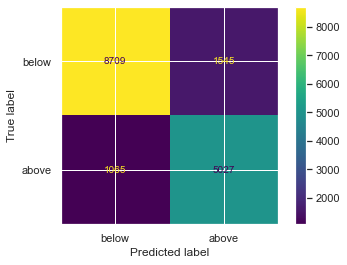

In [122]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(train_dataset['price_category2'], train_dataset['thresh_04'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['below', 'above'])

disp.plot();

In [123]:
from sklearn.metrics import classification_report

target_names = ['below', 'above']
print(classification_report(train_dataset['price_category2'], train_dataset['thresh_04'], target_names=target_names))

              precision    recall  f1-score   support

       below       0.89      0.85      0.87     10254
       above       0.76      0.83      0.79      6092

    accuracy                           0.84     16346
   macro avg       0.83      0.84      0.83     16346
weighted avg       0.84      0.84      0.84     16346



### Threshold 0.5

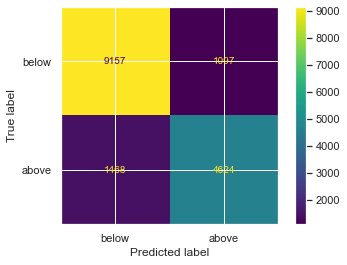

In [124]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(train_dataset['price_category2'], train_dataset['thresh_05'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['below', 'above'])

disp.plot();

In [125]:
from sklearn.metrics import classification_report

target_names = ['below', 'above']
print(classification_report(train_dataset['price_category2'], train_dataset['thresh_05'], target_names=target_names))

              precision    recall  f1-score   support

       below       0.86      0.89      0.88     10254
       above       0.81      0.76      0.78      6092

    accuracy                           0.84     16346
   macro avg       0.84      0.83      0.83     16346
weighted avg       0.84      0.84      0.84     16346



### Threshold 0.7

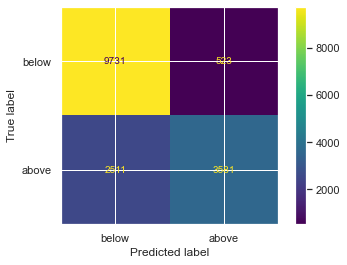

In [126]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(train_dataset['price_category2'], train_dataset['thresh_07'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['below', 'above'])

disp.plot();

In [127]:
from sklearn.metrics import classification_report

target_names = ['below', 'above']
print(classification_report(train_dataset['price_category2'], train_dataset['thresh_07'], target_names=target_names))

              precision    recall  f1-score   support

       below       0.79      0.95      0.87     10254
       above       0.87      0.59      0.70      6092

    accuracy                           0.81     16346
   macro avg       0.83      0.77      0.78     16346
weighted avg       0.82      0.81      0.80     16346



Threshold 0.4 and Threshold 0.5 have very similar values. Same results for f1-score but Threshold 0.5 has a bit better values for the precision and Threshold 0.4 has a better values for the recall. As we went to optimize the recall, Threshold 0.4 is the best and should be used

## Use test data

Now lets check the performance of the model with our test data

In [128]:
# Predict test data
y_score_test = model.predict(X_test)

thresh_04_test = np.where(y_score_test > 0.4, 1, 0)

print(classification_report(y_test, thresh_04_test, target_names=target_names))

              precision    recall  f1-score   support

       below       0.90      0.86      0.88      2629
       above       0.76      0.82      0.79      1458

    accuracy                           0.84      4087
   macro avg       0.83      0.84      0.83      4087
weighted avg       0.85      0.84      0.85      4087



Also very good performancec here! That means this models work good on the training and on the test data, therefore this model works very good. Moreover the defined metric of a predicted recall of more than 0.8 was achieved. Therefore this project was successful!

In [129]:
# Drop created features before modelling with scikit
train_dataset = train_dataset.drop(['y_score', 'thresh_04', 'thresh_05', 'thresh_07'], axis=1)

In [130]:
train_dataset

,median_housing_age,population,households,median_income,ocean_proximity,avg_rooms_per_household,avg_bedrooms_per_household,avg_size_per_household,price_category2
4353,39.0,975,525,93092.0,<1H OCEAN,7.23,1.12,1.86,0
6847,42.0,656,215,41902.0,<1H OCEAN,4.82,0.93,3.05,0
18321,37.0,510,206,79029.0,NEAR BAY,6.25,0.96,2.48,0
10987,23.0,1574,642,50210.0,<1H OCEAN,5.45,0.99,2.45,0
3115,14.0,850,317,25812.0,INLAND,5.49,1.23,2.68,1
...,...,...,...,...,...,...,...,...,...
9464,47.0,552,201,25192.0,<1H OCEAN,5.72,1.21,2.75,1
7373,44.0,3913,842,30143.0,<1H OCEAN,3.78,1.04,4.65,1
17897,36.0,1589,387,31065.0,<1H OCEAN,4.71,1.06,4.11,0
7375,47.0,1097,274,28810.0,<1H OCEAN,3.86,1.08,4.00,0


### Model - scikit learning

Actually I was not sure how to make the preprocessor pipeline for the classification. Due to the fact that it did not work, I skipped it.

I assume that the dummy variables need to be added for the scikit learning model, because without them I got errors that the string could not be transferred to float.
If I add the dummy variables, the code tells me that it is not possible, because he can not convert boolean and the columns are not included, even if they are listed in the dataframe/test_dataset. Therefore the model wont contain the categorical varable. Moreover I will drop it, because Ocean_proximity Island has a high p-value. --> So i also have an argumentation why I drop that variable from a logical point of view :)

On the classification notebook it worked, but I do not know why and what was the difference...

In [131]:
# change the column Ocean Proximity to dummy variables
#dummies = pd.get_dummies(train_dataset[['ocean_proximity']], drop_first=True, dtype=float)

In [132]:
# change the column Ocean Proximity to dummy variables
#dummies = pd.get_dummies(df[['ocean_proximity']], drop_first=True, dtype=float)

In [133]:
#dummies.info()

In [134]:
#print(dummies.head)

In [135]:
# combine data and drop original categorical variables
#train_dataset = pd.concat([train_dataset, dummies], axis=1).drop(columns = ['ocean_proximity'])
#train_dataset.head(3)

In [136]:
# combine data and drop original categorical variables
#df = pd.concat([df, dummies], axis=1).drop(columns = ['ocean_proximity'])
#df.head(3)

In [137]:
# drop median house value (as it is will be included in y, drop price_category as we want to predict it and drop ocean_proximity as it will be added via the dummy variables)
#X_numerical = train_dataset.drop(['median_income', 'price_category2', 'ocean_proximity', 'population', 'households', 'avg_rooms_per_household', 'avg_bedrooms_per_household', 'y_score', 'thresh_04', 'thresh_05' , 'thresh_07'], axis=1).astype('float64')

In [138]:
#list_numerical = X_numerical.columns
#list_numerical

In [139]:
# only use meaningful predictors
#features_model = pd.concat([X_numerical, dummies[['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']]], axis=1)
features_model = ['median_income', 'median_housing_age', 'avg_size_per_household']

X_train = X_train[features_model] 
X_test = X_test[features_model]

In [140]:
import sklearn.linear_model as skl_lm

# model
clf = skl_lm.LogisticRegressionCV(penalty='l2')
# prediction: Model is fitted on the trainings data and directly predicting for the test data, Therefore this validation with the test data is made in this step and not seperatly
y_pred = clf.fit(X_train, y_train).predict(X_test)

### Classification metrics

In [141]:
# Return the mean accuracy on the given test data and labels:
clf.score(X_test, y_test)

0.7560557866405676

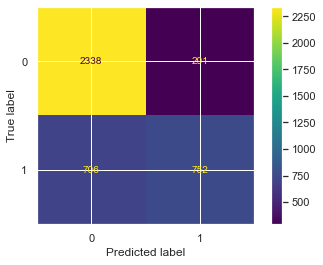

In [142]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [143]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['below', 'above']))

              precision    recall  f1-score   support

       below       0.77      0.89      0.82      2629
       above       0.72      0.52      0.60      1458

    accuracy                           0.76      4087
   macro avg       0.74      0.70      0.71      4087
weighted avg       0.75      0.76      0.74      4087



The results from this model are worse than those from the statsmodel which included the ocean_proximity

## Thresholds


In [144]:
pred_proba = clf.predict_proba(X_test)

### Threshold 0.4

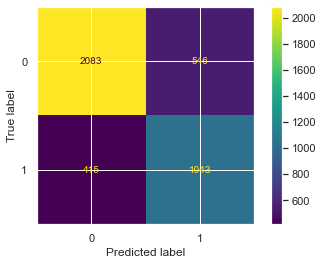

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      2629
           1       0.66      0.72      0.68      1458

    accuracy                           0.76      4087
   macro avg       0.75      0.75      0.75      4087
weighted avg       0.77      0.76      0.77      4087



In [145]:
df_ = pd.DataFrame({'y_test': y_test, 'y_pred': pred_proba[:,1] > .4})
cm = confusion_matrix(y_test, df_['y_pred'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

print(classification_report(y_test, df_['y_pred']))

Threshold 0.4 delivers better values for the precision, recall and  f1-score than the threshold 0.5

### Threshold 0.5

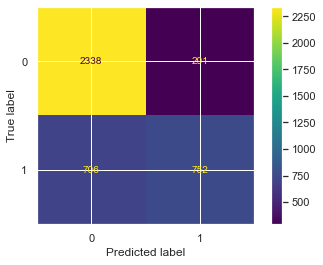

              precision    recall  f1-score   support

           0       0.77      0.89      0.82      2629
           1       0.72      0.52      0.60      1458

    accuracy                           0.76      4087
   macro avg       0.74      0.70      0.71      4087
weighted avg       0.75      0.76      0.74      4087



In [146]:
df_ = pd.DataFrame({'y_test': y_test, 'y_pred': pred_proba[:,1] > .5})
cm = confusion_matrix(y_test, df_['y_pred'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

print(classification_report(y_test, df_['y_pred']))

### Threshold 0.7

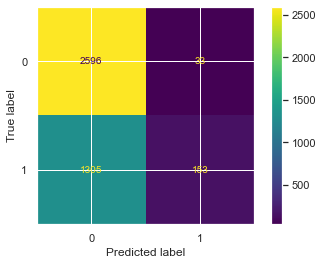

              precision    recall  f1-score   support

           0       0.67      0.99      0.80      2629
           1       0.82      0.10      0.19      1458

    accuracy                           0.67      4087
   macro avg       0.74      0.55      0.49      4087
weighted avg       0.72      0.67      0.58      4087



In [147]:
df_ = pd.DataFrame({'y_test': y_test, 'y_pred': pred_proba[:,1] > .7})
cm = confusion_matrix(y_test, df_['y_pred'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

print(classification_report(y_test, df_['y_pred']))

Threshold 0.7 delivers the worst results. Therefore the threshold 0.4 is the best for this model.

**Conclusion:**
Sadly this model is not sufficient for the goals which were set on the beginning of the notebook (Recall of atleast 0.8). Therefore this model has failed. But the model made with statsmodel (including the parameter: ocean_proximity) fullfills the requirements and that model makes this project successful :)